 # Transpiler Stages & Preset PassManagers

Qiskit includes functions to build preset `PassManager` objects.  These are objects which manage a set of different `Passes` which can include things like transforming the operations in your quantum circuit, optimize the selection of qubits to be used on the target backend, and other optimizations which improve the overall efficiency of your circuit and suppress the effects of noise.  In this document, we will look at the default passes when running `qiskit.compiler.transpile()` or when setting the `optimization_level` of a Runtime object.


When the `transpile()` function is called, a preset `StagedPassManager` object is created and then executed.  There are 4 different preset pass managers ranging from very light to heavy optimization and specified by the `optimization_level` argument which can range from 0 to 3.  Higher optimization levels take more time and computational effort but may yield more optimal circuits.  Optimization level 0 is intended for device characterization experiments and, as such, only maps the input circuit to the constraints of the target backend, without performing any optimizations.  Optimization level 3 spends the most effort optimizing the circuit.  However, as many of the optimization techniques in the transpiler are heuristic based, spending more computational effort does not always result in an improvement in the quality of the output circuit.  For specific details on the preset pass managers, look to the [API reference section](../api/qiskit/transpiler_preset.md).

We'll now expand upon each stage of these preset pass managers which provide a useful framework for optimizing your quantum algorithms.  Recall that these stages are:


1. `init` - This pass runs any initial passes that are required before we start embedding the circuit to the backend.  This typically involves unrolling custom instructions and converting the circuit to all single- and two-qubit gates.
1. `layout` - This pass applies a *layout*, mapping/assigning the virtual qubits in your circuit to the physical qubits of a backend.
1. `routing` - This pass runs after a layout has been applied and will inject gates (i.e., SWAPs) in the original circuit in order to make it compatible with the backend's connectivity/coupling map.
1. `translation` - This pass translates the gates in the circuit to the backend's basis set of instructions.
1. `optimization` - This pass runs an optimization loop to find more efficient decompositions of your quantum circuit until a condition is met (such as a fixed depth).
1. `scheduling` - This pass is for any hardware-aware optimizations that improves the efficiency of the executed microwave pulse instructions.




## Init Stage

This first stage does very little by default and is primarily useful if you would want to include your own initial optimizations.  Because most layout and routing algorithms are only designed to work with 1 and 2 qubit gates, this stage is also used to translate any gates that operate on more than 2 qubits into gates that only operate on 1 or 2 qubits.

For more information about utilizing your own initial optimizations you would like to run for this stage, see the section on plugins and customizing pass managers.

## Layout Stage
In the next stage, we start considering the layout or connectivity of the backend a circuit will be sent to.  In general, quantum circuits are abstract entities whose qubits are "virtual" or "logical" representations of actual qubits used in computations.  In order to execute a sequence of gates, a one-to-one mapping from the "virtual" qubits to the "physical" qubits in an actual quantum device.  This mapping is stored as a `Layout` object.


![Qubit Mapping](../../public/images/transpile/layout-mapping.png)

The choice of mapping is extremely important for minimizing the number of swap operations needed to map the input circuit onto the device topology ancd ensure the most well-calibrated qubits are utilized.  Due to the improtance of this stage, the preset pass managers try a few different methods to find the best layout.  Typically this involves 2 steps: first, trying to find a "perfect" layout (a layout which does not require any swap operations), and then, a heuristic pass that tries to find the best layout to use if a perfect layout cannot be found.  There are 2 `Passes` typically used for this first step:

- `TrivialLayout`: Naively maps each virtual qubit to same numbered physical qubit on the device (i.e. [`0`,`1`,`1`,`3`] -> [`0`,`1`,`1`,`3`]).  This is historical behavior only used in `optimzation_level=1` to try to find a perfect layout.  If it fails, `VF2Layout` is tried next.
- `VF2Layout`: This is an `AnalysisPass` which works to select an ideal layout by treating this stage as a subgraph isomorphism problem, solved by the VF2++ algorithm.  If more than one layout is found, a scoring heuristic is run to select the mapping with the lowest average error.

Then for the heuristic stage, 2 passes are used by default:

- `DenseLayout`: Findsthe sub-graph of the device with the greatest connectivity and that has the same number of qubits as the circuit.  (Used for )
- `SabreLayout`: This pass selects a layout by starting from an initial random layout and repeatedly running the `SabreSwap` algorithm.  This pass is only used in optimization levels 1, 2, and 3 if a perfect layout isn't found via the `VF2Layout` pass.  More details on this algorithm please refer to the paper: [arXiv:1809.02573](https://arxiv.org/abs/1809.02573)


## Routing Stage

In order to implement a 2-qubit gate between qubits that are not directly connected on a quantum device, one or more swap gates must be inserted into the circuit to move the qubit states around until they are adjacent on the device gate map.  Each swap gate represents an expensive and noisy operation to perform.  Thus, finding the minimum number of swap gates needed to map a circuit onto a given device is an important step in the whole transpilation process.  For efficiency, this stage typically computed alongside the Layout stage by default, but they are logically distinct from one another.  The *Layout* stage selects the hardware qubits to be used and the *Routing* stage inserts the appropriate amount of swap gates in order to execute the circuits using the selected layout.

However this may come as no surprise that there's no free lunch here and that finding the optimal swap mapping is hard.  In fact it is what is known as an NP-hard problem, and is thus prohibitively expensive to compute for all but the smallest quantum devices and input circuits.  To get around this, Qiskit uses a stochastic heuristic algorithm called `SabreSwap` to compute a good, but not necessarily optimal swap mapping. The use of a stochastic method means that the circuits generated by `transpile()` are not guaranteed to be the same over repeated runs.  Indeed, running the same circuit repeatedly will result in a distribution of circuit depths and gate counts at the output.  It is for this reason that many users choose to run routing function (or the entire `StagedPassManager`) many times and select the lowest depth circuits from the distribution of outputs.

It's also important to point out here that the `SabreSwap` algorithm is different from the larger `SabreLayout` method in the previous stage.  By default `SabreLayout` will run both layout and routing and will return the transformed circuit.  This is done for a few particular technical reasons that is specified in the pass's [API reference page](../api/qiskit.transpiler.passes.SabreLayout). 

## Translation Stage

When writing a quantum circuit you are free to use any quantum gate (unitary operation) that you like, along with a collection of non-gate operations such as qubit measurement or reset instructions.  However, most quantum devices only natively support a handful of quantum gate and non-gate operations. This stage of the preset `PassManagers` will  translate (or *unroll*) the gates specified in a circuit to the native basis gates of a specified backend.  This is an important step as it allows the circuit to be executed by the backend, but will typically lead to an increase in the depth and the number of gates.

There two special cases which are especially important to highlight, and illustrate a bit more clearly what this stage does:

1. If a swap gate is not a native gate to the target backend, this requires three CNOT gates:

['rz', 'sx', 'x', 'ecr', 'measure', 'delay']


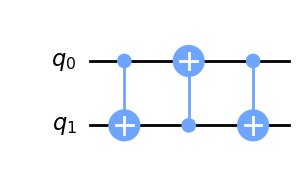

In [ ]:
from qiskit.providers.fake_provider import FakeSherbrooke
from qiskit import QuantumCircuit

backend = FakeSherbrooke()
print(backend.operation_names)
qc = QuantumCircuit(2)
qc.swap(0, 1)
qc.decompose().draw('mpl')

As a product of three CNOT gates, SWAPs are expensive operations to perform on noisy quantum devices.  However, such operations are usually necessary for embedding a circuit into the limited gate connectivities of many devices.  Thus, minimizing the number of swap gates in a circuit is a primary goal in the process of transpilation.

2. A Toffoli, or controlled-controlled-not gate (`ccx`), is a three-qubit gate.  Given that our basis gate set includes only single and two-qubit gates, it is obvious that this operation must be decomposed.  However it is quite costly:

['rz', 'sx', 'x', 'ecr', 'measure', 'delay']


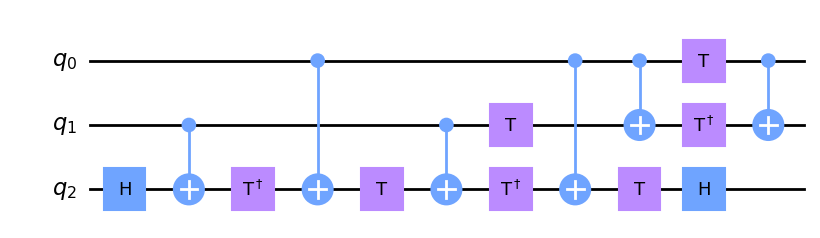

In [ ]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc.decompose().draw('mpl')

For every Toffoli gate in a quantum circuit, the hardware may execute up to six CNOT gates, and a handful of single-qubit gates.  From this example, it should be clear that any algorithm that makes use of multiple Toffoli gates will end up as a circuit with large depth and will therefore be appreciably affect by noise.

## Optimization Stage

This stage centers around decomposing quantum circuits into the basis gate set of the target device, and must fight against the increased depth from the layout and routing stages.  Fortunately, many routines for optimizing circuit by either combining or eliminating gates exist.  In some cases, these methods are so effective that the output circuits have lower depth than the inputs, even after layout and routing to the hardware topology.  In other cases, not much can be done, and the computation may be difficult to perform on noisy devices.  This stage is where the various optimization levels begin to differ.

- For `optimization_level=1`, this stage will prepare the [`Optimize1qGatesDecomposition`](../api/qiskit/qiskit.transpiler.passes.Optimize1qGatesDecomposition.md) and [`CXCancellation`](../api/qiskit/qiskit.transpiler.passes.CXCancellation.md) which will combine chains of single-qubit gates and cancel any back-to-back CNOT gates.
- For `optimization_level=2`, this stage will use the [`CommutativeCancellation`](../api/qiskit/qiskit.transpiler.passes.CommutativeCancellation.md) pass instead of `CXCancellation` which remove redundant gates by exploiting commutation relations.
- For `optimization_level=3` this stage will prepare the following passes:
  - [`Collect2qBlocks`](../api/qiskit/qiskit.transpiler.passes.Collect2qBlocks.md)
  - [`ConsolidateBlocks`](../api/qiskit/qiskit.transpiler.passes.ConsolidateBlocks.md)
  - [`UnitarySynthesis`](../api/qiskit/qiskit.transpiler.passes.UnitarySynthesis.md)
  - [`Optimize1qGateDecomposition`](../api/qiskit/qiskit.transpiler.passes.Optimize1qGatesDecomposition.md)
  - [`CommutativeCancellation`](../api/qiskit/qiskit.transpiler.passes.CommutativeCancellation.md)


Additionally, this stage will also execute a few final checks to make sure that all instructions in the circuit are composed of the basis gates available on the target backend.

## Scheduling

Once the circuit has been translated to the target basis, mapped to the device, and optimized, a scheduling pass will be applied to account for all the idle time in the circuit.  At a high level, the scheduling pass can be thought of as inserting delay instructions to account for the idle time between gate executions.  The scheduling of a circuit involves two parts: analysis and constraint mapping, followed by a padding pass.  The first part requires running a scheduling analysis pass (by default this is [`ALAPSchedulingAnalysis`](../api/qiskit/qiskit.transpiler.passes.ALAPScheduleAnalysis.md)) which analyzes the circuit and records the start time of each instruction in the circuit into a schedule.  Once the circuit has an initial schedule, additional passes can be run to account for any timing constraints on the target backend.  Finally, a padding pass, such as [`PadDelay`](../api/qiskit/qiskit.transpiler.passes.PadDelay.md) or [`PadDynamicalDecoupling`](../api/qiskit/qiskit.transpiler.passes.PadDynamicalDecoupling.md) are executed